In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import dateutil.parser
import math
import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid")

#import Levenshtein

from pandas.api.types import CategoricalDtype

from matplotlib import pyplot

# Read into Pandas dataframe with explicit schema

* **`interview_date`**
* **`client_name`**
* **`industry`**: vertical the client belongs to (note that candidates can jump across verticals in their job hunt)
* **`location`**: refers to the current location of the candidate
* **`position_to_be_closed`**: **Niche** refers to rare skill sets while **Routine** refers to more common skill sets
* **`skillset`**: skill the client has
* **`interview_type`**: There are three types of interview
    * **Walkin drives**: these are unscheduled. Candidates are either contacted or they come to the interview on their own volition, 
    * **Scheduled**: Here the candidates profiles are screened by the client and subsequent to this, the vendor fixes an appointment between the client and the candidate. T
    * **Scheduled Walkin**: Here the number of candidates is larger and the candidates are informed beforehand of a tentative date to ascertain their availability. The profiles are screened as in a scheduled interview. In a sense it bears features of both a walk-in and a scheduled interview
* **`name`**: Candidate XXXX
* **`gender`**
* **`location`**: candidate location
* **`job_location`**
* **`interview_venue`**
* **`candidate_native_location`**
* **`q_start_time`**
* **`q_unsch_mtgs`**
* **`q_call_3hrs`**
* **`q_alt_number`**
* **`q_resume`**
* **`q_venue`**
* **`q_call_letter`**
* **`attended`**
* **`marital`**

In [2]:
column_names = [
'interview_date_rawstr',
'client_name',
'industry',
'location',
'position_to_be_closed',
'skillset',
'interview_type',
'name',
'gender',
'current_location',
'job_location',
'interview_venue',
'candidate_native_location',
'q_start_time',
'q_unsch_mtgs',
'q_call_3hrs',
'q_alt_number',
'q_resume',
'q_venue',
'q_call_letter',
'attended',
'marital',
]

In [3]:
file_name = 'Interview_Attendance_Data.csv'
df = pd.read_csv(
    file_name, 
    header=0, 
    #dtype=policy_cols, 
    usecols=lambda col: not col.startswith('Unnamed'),
    parse_dates=['Date of Interview']
)
n_raw = df.shape[0]
print(f'Read {n_raw} rows from {file_name}')

Read 1233 rows from Interview_Attendance_Data.csv


In [4]:
len(column_names) #df.columns)
df.columns = column_names

In [5]:
#df = df[df['attended'].notnull()]
n = df.shape[0]
#print(f'{n} rows with non-null response')

## Initial missing data 
* `attended`, the response variable has 93 nulls, which are to be used to make predictions for submission
* `q_*`, the pre-cursor question indicators have varying degrees of fill rate, but I'm going to assume the answer is "No", if it is missing.  Risky, because perhaps it just wasn't recorded by the person capturing the data or that the questions weren't asked of all candidates.

In [6]:
pd.DataFrame({
    'non_null': df.count(),
    'null': df.isnull().sum()
}).sort_values('non_null', ascending=False).T #, inplace=True)

,interview_date_rawstr,name,candidate_native_location,client_name,job_location,current_location,gender,interview_venue,interview_type,skillset,position_to_be_closed,location,industry,marital,attended,q_start_time,q_call_letter,q_unsch_mtgs,q_call_3hrs,q_alt_number,q_resume,q_venue
non_null,1233,1233,1233,1233,1233,1233,1233,1233,1233,1233,1233,1233,1233,1233,1140,1029,988,986,986,986,985,985
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93,204,245,247,247,247,248,248


In [7]:
df.dtypes

interview_date_rawstr        object
client_name                  object
industry                     object
location                     object
position_to_be_closed        object
skillset                     object
interview_type               object
name                         object
gender                       object
current_location             object
job_location                 object
interview_venue              object
candidate_native_location    object
q_start_time                 object
q_unsch_mtgs                 object
q_call_3hrs                  object
q_alt_number                 object
q_resume                     object
q_venue                      object
q_call_letter                object
attended                     object
marital                      object
dtype: object

## `attended`
### After some simple cleaning, we have a reasonable class balance of about 4:7.

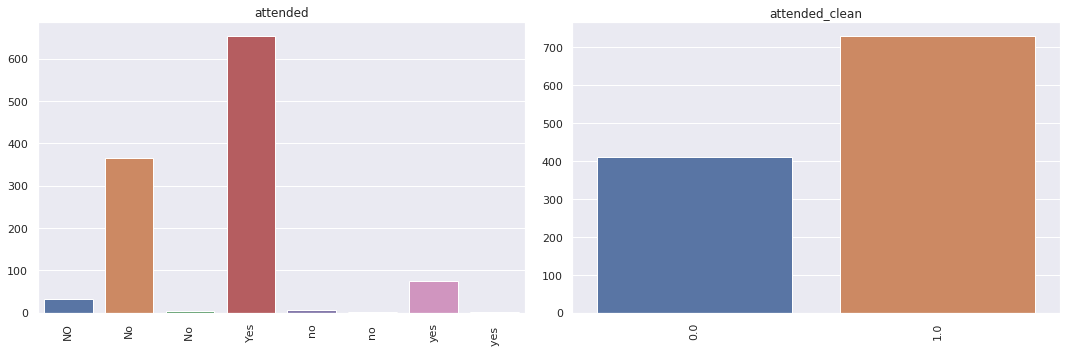

1140 non-null attended values


In [8]:
def parse_attended(s):
    if not pd.isna(s):
        tmp = s.strip().upper()
        if tmp == 'YES':
            return 1.0
        else:
            return 0.0
    else:
        return s
        
df['attended_clean'] = df['attended'].apply(parse_attended)  # lambda s: if not pd.isnan(s): s.strip().upper())

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(bottom=0.01)

attended = df.groupby('attended').count()[['name']].reset_index()
attended_plot = sns.barplot(x=attended['attended'], y=attended['name'], ax=ax[0])  
ax[0].set(xlabel='', ylabel='', title='attended')
for item in attended_plot.get_xticklabels():
    item.set_rotation(90)
    
attended = df.groupby('attended_clean').count()[['name']].reset_index()
attended_plot = sns.barplot(x=attended['attended_clean'], y=attended['name'], ax=ax[1])  
ax[1].set(xlabel='', ylabel='', title='attended_clean')
for item in attended_plot.get_xticklabels():
    item.set_rotation(90)    
    
plt.tight_layout()
plt.show()    

print(df.attended_clean.count(), 'non-null attended values')

## Conflation and Cleaning of majority of data fields
Most of the categorical data fields an be conflated, as there are a number of categories that are sparse and can be put into a 'catch-all' `OTHER` category

In [9]:
def clean_by_map(col_name: str, df: pd.DataFrame, threshold: int=50) -> None:
    gp_by = df.groupby(col_name).count()[['name']].reset_index()
    
    x = gp_by.values.tolist()
    x.sort(key=lambda x: x)
    
    cat_map = {}
    for v in x:
        if v[1] > threshold:
            cat_map[v[0]] = v[0].strip().upper()
        else:
            cat_map[v[0]] = 'OTHER'
            
    df[f'{col_name}_clean'] = df[col_name].apply(lambda s: cat_map[s])    

### Plots on left hand side are original data and the right hand side are the cleaned and conflated data

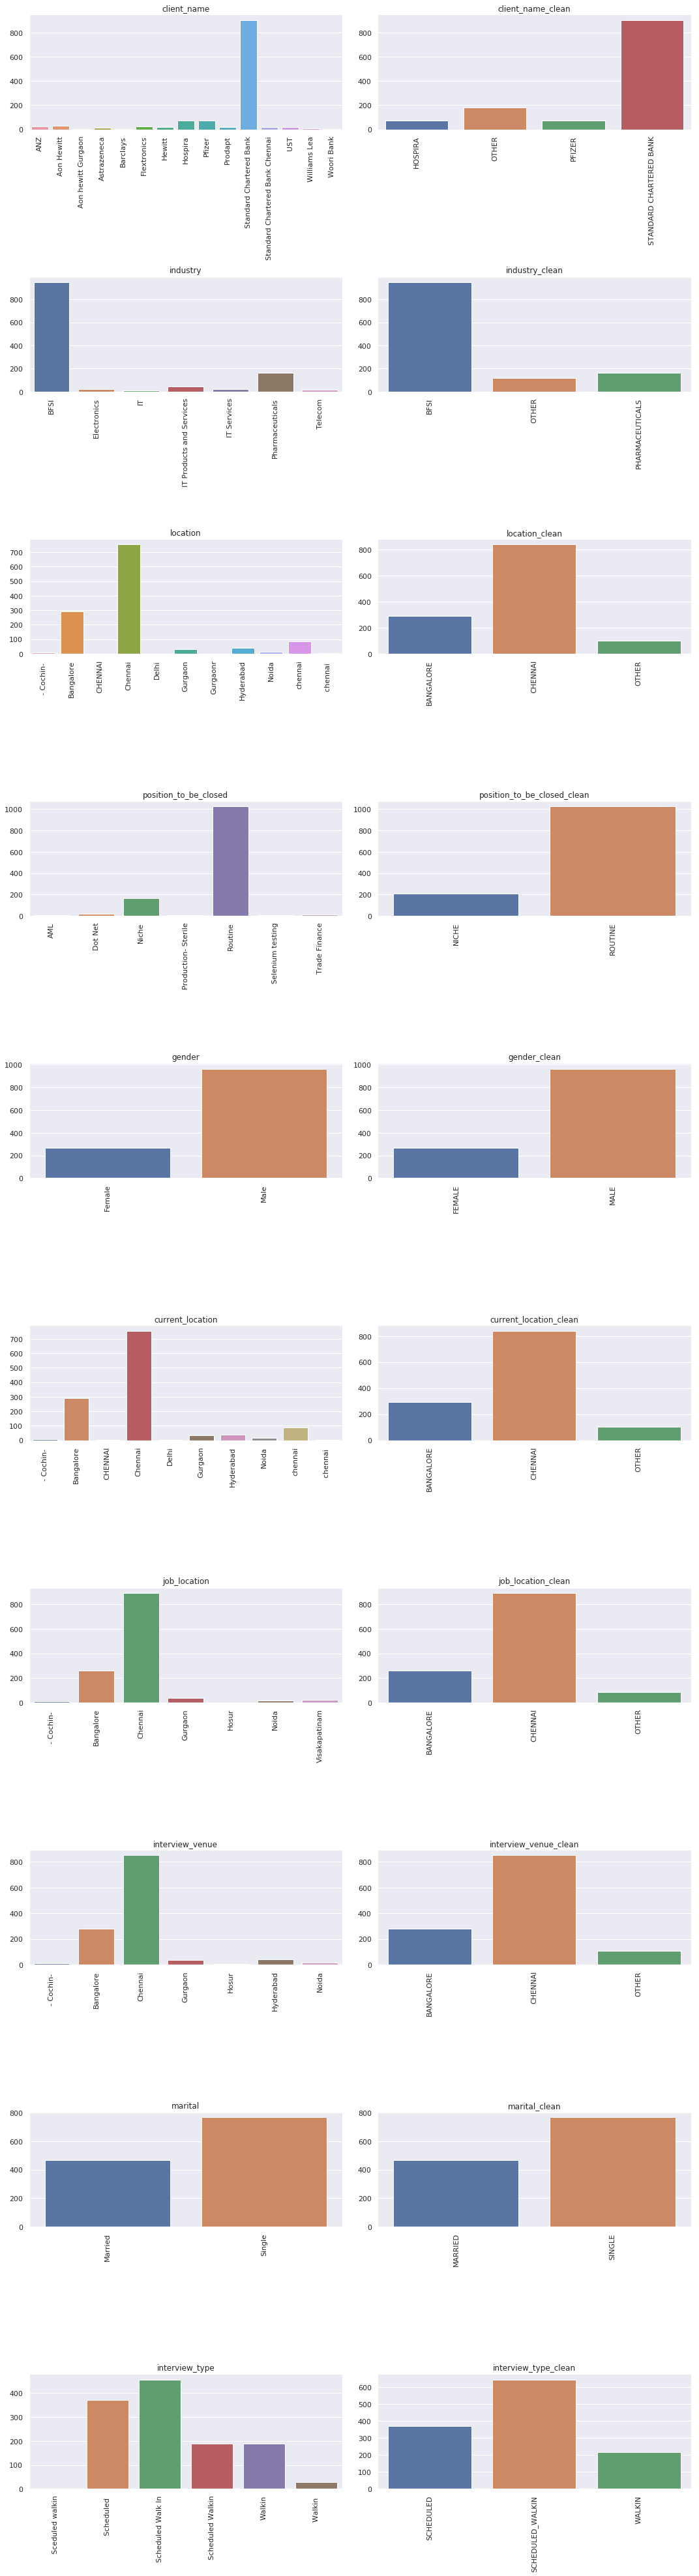

In [10]:
fig, ax = plt.subplots(10, 2, figsize=(15, 55))
plt.subplots_adjust(bottom=0.01)

cols_to_clean = ['client_name', 'industry', 'location', 'position_to_be_closed', #'interview_type',
                 'gender', 'current_location', 'job_location', 'interview_venue', 'marital']

for row_idx, col_name in enumerate(cols_to_clean):
    gp_by = df.groupby(col_name).count()[['name']].reset_index()
    raw_plot = sns.barplot(x=gp_by[col_name], y=gp_by['name'], ax=ax[row_idx][0])  
    ax[row_idx][0].set(xlabel='', ylabel='', title=col_name)
    for item in raw_plot.get_xticklabels():
        item.set_rotation(90)
        
    clean_by_map(col_name, df)
    
    if col_name == 'position_to_be_closed':
        df.loc[df.position_to_be_closed_clean=='OTHER', ['position_to_be_closed_clean']] = 'NICHE'
    
    clean_col_name = f'{col_name}_clean'
    gp_by_clean = df.groupby(clean_col_name).count()[['name']].reset_index()
    clean_plot = sns.barplot(x=gp_by_clean[clean_col_name], y=gp_by_clean['name'], ax=ax[row_idx][1])  
    ax[row_idx][1].set(xlabel='', ylabel='', title=clean_col_name)
    for item in clean_plot.get_xticklabels():
        item.set_rotation(90)
  
row_idx += 1
col_name = 'interview_type'

gp_by = df.groupby(col_name).count()[['name']].reset_index()
raw_plot = sns.barplot(x=gp_by[col_name], y=gp_by['name'], ax=ax[row_idx][0])  
ax[row_idx][0].set(xlabel='', ylabel='', title=col_name)
for item in raw_plot.get_xticklabels():
    item.set_rotation(90)

def int_type_conflation(s):
    tmp = s.strip().upper()
        
    if 'SCHEDULED' in tmp and 'WALK' in tmp:
        return 'SCHEDULED_WALKIN'
    elif 'SCHEDULED' in tmp and 'WALK' not in tmp:
        return 'SCHEDULED'
    elif 'WALK' in tmp:
        return 'WALKIN'
    else:
        return 'OTHER'
        
df[f'{col_name}_clean'] = df[col_name].apply(int_type_conflation)

clean_col_name = f'{col_name}_clean'
gp_by_clean = df.groupby(clean_col_name).count()[['name']].reset_index()
clean_plot = sns.barplot(x=gp_by_clean[clean_col_name], y=gp_by_clean['name'], ax=ax[row_idx][1])  
ax[row_idx][1].set(xlabel='', ylabel='', title=clean_col_name)
for item in clean_plot.get_xticklabels():
    item.set_rotation(90)       

plt.tight_layout()
plt.show()

## `candidate_native_location`
Conflation can be accomplished here with some simpler things:
* `Cochin` and `-Cochin-` can be conflated
* `Delhi` and `Delhi/NCR` can be conflated

Data has the majority of support for `Bangalore`, `Chennai` and `Hyderabad`... sooo, let's just make four categories: `Bangalore`, `Chennai` and `Hyderabad` and `Other`.

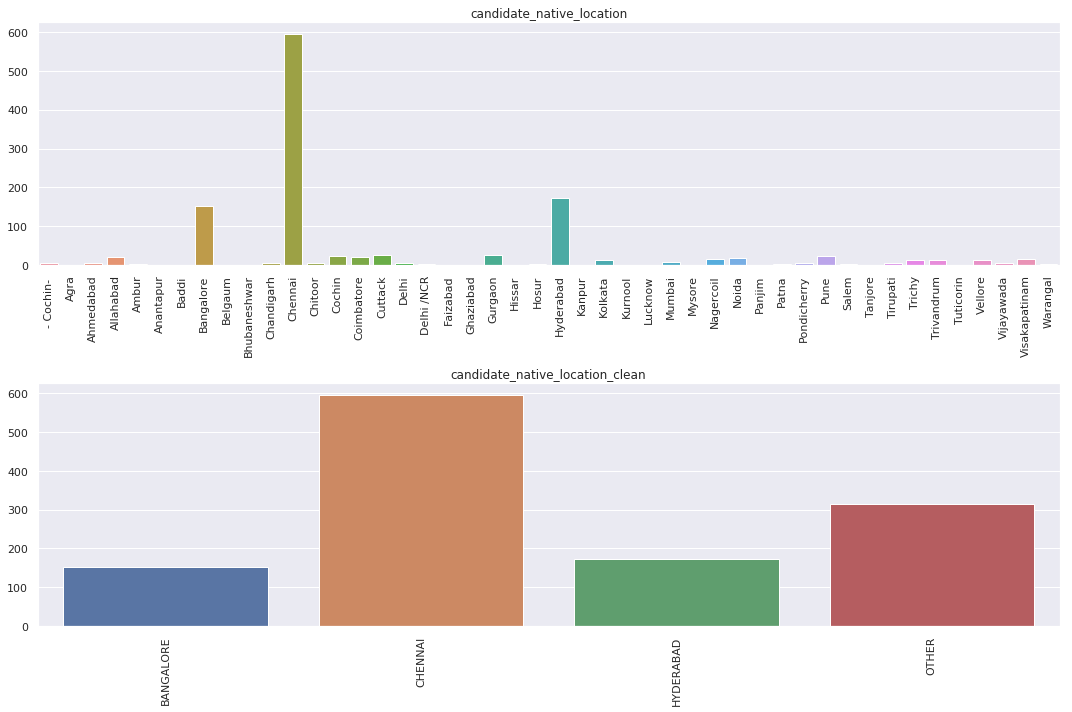

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plt.subplots_adjust(bottom=0.01)

candidate_native_location = df.groupby('candidate_native_location').count()[['name']].reset_index()
candidate_native_location_plot = sns.barplot(x=candidate_native_location['candidate_native_location'], y=candidate_native_location['name'], ax=ax[0])  
ax[0].set(xlabel='', ylabel='', title='candidate_native_location')
for item in candidate_native_location_plot.get_xticklabels():
    item.set_rotation(90)

df['candidate_native_location'] = df['candidate_native_location'].apply(lambda s: s.strip().replace('-', ''))

clean_by_map('candidate_native_location', df)

candidate_native_location = df.groupby('candidate_native_location_clean').count()[['name']].reset_index()
candidate_native_location_plot = sns.barplot(x=candidate_native_location['candidate_native_location_clean'], y=candidate_native_location['name'], ax=ax[1])  
ax[1].set(xlabel='', ylabel='', title='candidate_native_location_clean')
for item in candidate_native_location_plot.get_xticklabels():
    item.set_rotation(90)    
        
plt.tight_layout()
plt.show()

## `skillset`

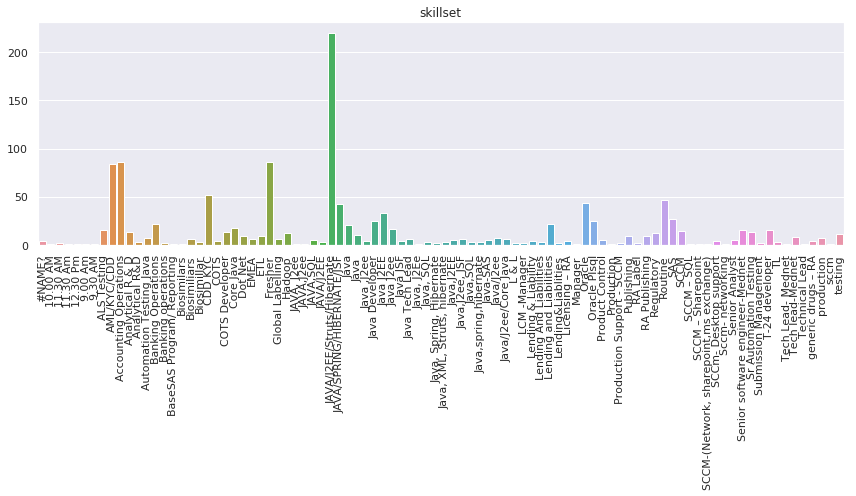

In [12]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.subplots_adjust(bottom=0.01)

skillset = df.groupby('skillset').count()[['name']].reset_index()
skillset_plot = sns.barplot(x=skillset['skillset'], y=skillset['name'], ax=ax)  
ax.set(xlabel='', ylabel='', title='skillset')
for item in skillset_plot.get_xticklabels():
    item.set_rotation(90) 

plt.tight_layout()
plt.show()

In [13]:
skillsets = df['skillset'].unique().tolist()
skillsets.sort()

In [14]:
import re

def tokenize_skillset(s):
    raw_tokens = re.findall(r"[\w']+", s.upper())
    tokens = [t for t in raw_tokens if len(t) > 2]
    tokens.sort()
    if len(tokens) > 0:
        tmp = list(set(tokens))
        tmp.sort()
        return ' '.join(tmp)
    else:
        return 'NA'

In [15]:
new_cats = set()
for cat in skillsets:
    tokens = tokenize_skillset(cat)
    if len(tokens) > 0:
        print('CAT |', cat, '[', tokens, ']')
        new_cats.add(tokens)
    else:
        print('NA  |', cat)

CAT | #NAME? [ NAME ]
CAT | 10.00 AM [ NA ]
CAT | 11.30 AM [ NA ]
CAT | 11.30 Am [ NA ]
CAT | 12.30 Pm [ NA ]
CAT | 9.00 Am [ NA ]
CAT | 9.30 AM [ NA ]
CAT | ALS Testing [ ALS TESTING ]
CAT | AML/KYC/CDD [ AML CDD KYC ]
CAT | Accounting Operations [ ACCOUNTING OPERATIONS ]
CAT | Analytical R & D [ ANALYTICAL ]
CAT | Analytical R&D [ ANALYTICAL ]
CAT | Automation Testing Java [ AUTOMATION JAVA TESTING ]
CAT | Banking Operations [ BANKING OPERATIONS ]
CAT | Banking operations [ BANKING OPERATIONS ]
CAT | BaseSAS Program/ Reporting [ BASESAS PROGRAM REPORTING ]
CAT | Biosimilars [ BIOSIMILARS ]
CAT | Biosimiliars [ BIOSIMILIARS ]
CAT | Biosimillar [ BIOSIMILLAR ]
CAT | CDD KYC [ CDD KYC ]
CAT | COTS [ COTS ]
CAT | COTS Developer [ COTS DEVELOPER ]
CAT | Core Java [ CORE JAVA ]
CAT | Dot Net [ DOT NET ]
CAT | EMEA [ EMEA ]
CAT | ETL [ ETL ]
CAT | Fresher [ FRESHER ]
CAT | Global Labelling [ GLOBAL LABELLING ]
CAT | Hadoop [ HADOOP ]
CAT | JAVA, J2ee [ J2EE JAVA ]
CAT | JAVA,J2ee [ J2EE JAV

In [16]:
lst_cats = list(new_cats)
lst_cats.sort()
#lst_cats

Since three different clustering methods didn't really do a complete job, we'll consolidate manually:

Consolidate:
* Anything with `LEAD` in it
* Anything with `MANAGER` in it
* Anything with `TEST` in it
* Anything with `LENDING` in it
* Anything with `PUBLISHING` in it
* Anything with `REPORTING` or `ANALYST` in it --> `ANALYST`
* `SCCM`
* `JAVA`
* `BIOSIMILIARS`
* `['LENDING', 'LIABILITY'], ['LENDING', 'AND', 'LIABILITIES'], ['LENDING', 'AND', 'LIABILITIES'], ['LENDING', 'LIABLITIES']` --> `LENDING_LIABILITY`
* `['ORACLE'], ['ORACLE', 'PLSQL']` --> `ORACLE`
* `['BANKING', 'OPERATIONS'], ['ACCOUNTING', 'OPERATIONS']` --> `ACCOUNTING`
* `['COTS'], ['COTS', 'DEVELOPER']` --> `COTS`

Keep as is:
* `ALS Testing`
* `AML/KYC/CDD`
* `ROUTINE`
* `SAS`
* `CDD KYC`
* `FRESHER`

Everything else is `OTHER`


In [17]:
clusters = {}

clusters['LEAD'] = []
for cat in lst_cats:
    if 'LEAD' in cat:
        clusters['LEAD'].append(cat)
        
clusters['MANAGER'] = []
for cat in lst_cats:
    if any(x in cat for x in ['MANAGER', 'MANAGEMENT']):
        clusters['MANAGER'].append(cat)
        
clusters['TEST'] = []
for cat in lst_cats:
    if 'TEST' in cat:
        clusters['TEST'].append(cat)       

clusters['LENDING'] = []
for cat in lst_cats:
    if 'LENDING' in cat:
        clusters['LENDING'].append(cat) 
        
clusters['ANALYST'] = []
for cat in lst_cats:
    if any(x in cat for x in ['PUBLISHING', 'REPORTING', 'ANALYST', 'ANALYTICAL']):
        clusters['ANALYST'].append(cat)         

clusters['SCCM'] = []
for cat in lst_cats:
    if 'SCCM' in cat:
        clusters['SCCM'].append(cat) 
        
clusters['JAVA'] = []
for cat in lst_cats:
    if 'JAVA' in cat:
        clusters['JAVA'].append(cat)        

clusters['BIOSIMILARS'] = []
for cat in lst_cats:
    if any(x in cat for x in ['BIOSIMILARS', 'BIOSIMILIARS', 'BIOSIMILLAR']):
        clusters['BIOSIMILARS'].append(cat)  

clusters['ORACLE'] = []
for cat in lst_cats:
    if 'ORACLE' in cat:
        clusters['ORACLE'].append(cat)
        
clusters['ACCOUNTING'] = []
for cat in lst_cats:
    if any(x in cat for x in ['BANKING', 'ACCOUNTING']) and 'OPERATIONS' in cat:
        clusters['ACCOUNTING'].append(cat) 

clusters['COTS'] = []
for cat in lst_cats:
    if 'COTS' in cat:
        clusters['COTS'].append(cat)
        
clusters['SAS'] = []  
for cat in lst_cats:
    if 'SAS' in cat:
        clusters['SAS'].append(cat)

clusters['KYC'] = []  
for cat in lst_cats:
    if 'KYC' in cat:
        clusters['KYC'].append(cat) 

clusters['FRESHER'] = ['FRESHER']   
clusters['ETL'] = ['ETL', 'HADOOP'] 
clusters['LABELLING'] = ['GLOBAL LABELLING', 'LABEL']
clusters['DEVELOPER'] = ['DEVELOPER', 'ENGINEER MEDNET SENIOR SOFTWARE']
clusters['CONTROL'] = ['CONTROL PRODUCT']
clusters['DOTNET'] = ['DOT NET']
clusters['OTHER'] = ['ROUTINE', 'PRODUCTION', 'EMEA', 'LICENSING', 'NAME', 'REGULATORY', 'DRUGS GENERIC']
clusters['NA'] = ['NA']

In [18]:
skillset_map = {}
for k, lst in clusters.items():
    for l in lst:
        skillset_map[l] = k

#skillset_map

In [19]:
df['skillset_tokenized'] = df['skillset'].apply(tokenize_skillset)
df['skillset_clean'] = df['skillset_tokenized'].apply(lambda s: skillset_map[s])
df[['skillset', 'skillset_tokenized', 'skillset_clean']]

,skillset,skillset_tokenized,skillset_clean
0,Routine,ROUTINE,OTHER
1,Routine,ROUTINE,OTHER
2,Routine,ROUTINE,OTHER
3,Routine,ROUTINE,OTHER
4,Routine,ROUTINE,OTHER
...,...,...,...
1228,JAVA/J2EE/Struts/Hibernate,HIBERNATE J2EE JAVA STRUTS,JAVA
1229,Java,JAVA,JAVA
1230,Java,JAVA,JAVA
1231,EMEA,EMEA,OTHER


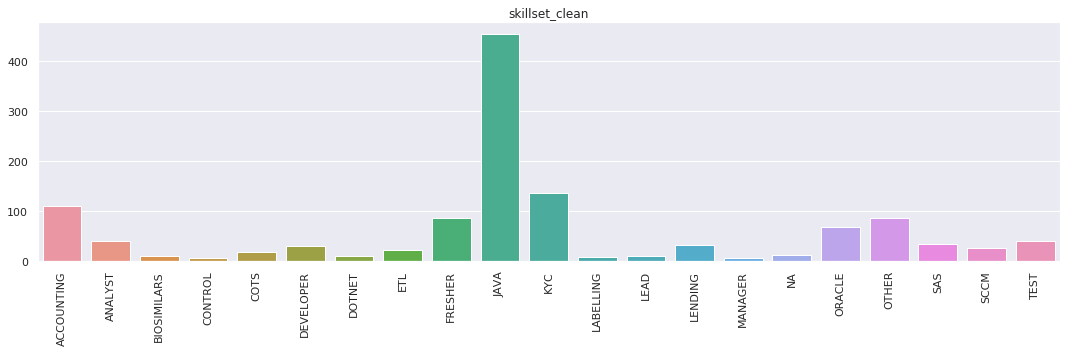

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.subplots_adjust(bottom=0.01)

skillset_clean = df.groupby('skillset_clean').count()[['name']].reset_index()
skillset_clean_plot = sns.barplot(x=skillset_clean['skillset_clean'], y=skillset_clean['name'], ax=ax)  
ax.set(xlabel='', ylabel='', title='skillset_clean')
for item in skillset_clean_plot.get_xticklabels():
    item.set_rotation(90)      
        
plt.tight_layout()
plt.show()

Still have some very low occurences (i.e. << 30):
* `BIOSIMILARS`
* `CONTROL`
* `DOTNET`
* `LABELLING`
* `LEAD`
* `MANAGER`
* `NA`

Let's put those into the `OTHER` category:

In [21]:
clusters['OTHER'] += clusters['BIOSIMILARS']
del clusters['BIOSIMILARS']

clusters['OTHER'] += clusters['CONTROL']
del clusters['CONTROL']

clusters['OTHER'] += clusters['DOTNET']
del clusters['DOTNET']

clusters['OTHER'] += clusters['LABELLING']
del clusters['LABELLING']

clusters['OTHER'] += clusters['LEAD']
del clusters['LEAD']

clusters['OTHER'] += clusters['MANAGER']
del clusters['MANAGER']

clusters['OTHER'] += clusters['NA']
del clusters['NA']

skillset_map = {}
for k, lst in clusters.items():
    for l in lst:
        skillset_map[l] = k
        
df['skillset_clean'] = df['skillset_tokenized'].apply(lambda s: skillset_map[s])
#df[['skillset', 'skillset_tokenized', 'skillset_clean']]

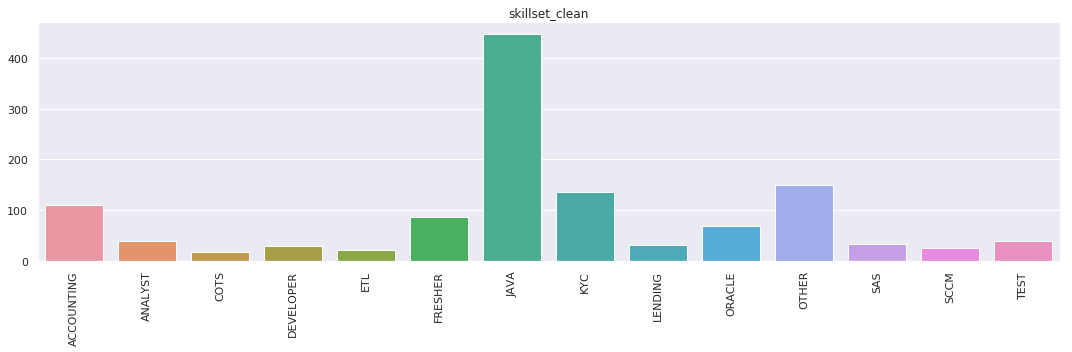

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.subplots_adjust(bottom=0.01)

skillset_clean = df.groupby('skillset_clean').count()[['name']].reset_index()
skillset_clean_plot = sns.barplot(x=skillset_clean['skillset_clean'], y=skillset_clean['name'], ax=ax)  
ax.set(xlabel='', ylabel='', title='skillset_clean')
for item in skillset_clean_plot.get_xticklabels():
    item.set_rotation(90)      
        
plt.tight_layout()
plt.show()

## `interview_date`

In [23]:
df.loc[:, ('interview_date')] = df.loc[:, ('interview_date_rawstr')].str.replace(' ', '').str.replace(' ', '').str.replace('–', '-').str.replace('.', '-').str.split('&').str[0]
df.loc[:, ('interview_date')] = df.loc[:, ('interview_date')].apply(dateutil.parser.parse)

In [24]:
df.loc[:, ('interview_date', 'interview_date_rawstr')].sort_values('interview_date', ascending=False)

,interview_date,interview_date_rawstr
667,2023-12-04,12.04.2023
666,2022-12-04,12.04.2022
145,2021-12-04,12.04.2021
665,2020-12-04,12.04.2020
664,2019-12-04,12.04.2019
...,...,...
759,2015-02-12,02.12.2015
961,2014-03-18,18.03.2014
962,2014-03-18,18.03.2014
963,2014-03-18,18.03.2014


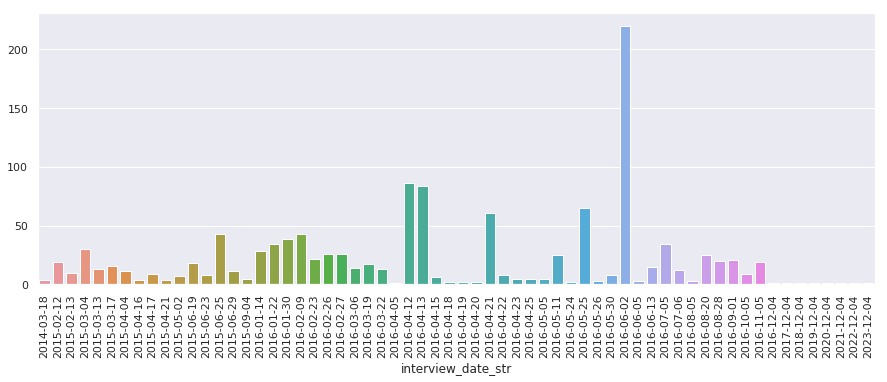

In [25]:
df.loc[:, ('interview_date_str')] = df.loc[:, ('interview_date')].dt.strftime('%Y-%m-%d') 

fig, ax = plt.subplots(figsize=(15, 5))
dt_histo = df.groupby('interview_date_str').count()[['name']].reset_index()
g = sns.barplot(x=dt_histo['interview_date_str'], y=dt_histo['name'], ax=ax)
g.set(xlabel='interview_date_str', ylabel='')
for item in g.get_xticklabels():
    item.set_rotation(90)
    
#fig.autofmt_xdate()  
plt.show()    

## Seasonality via month of `interview_date`

In [26]:
df.loc[:, ('interview_date_mo')] = df.loc[:, ('interview_date')].dt.month

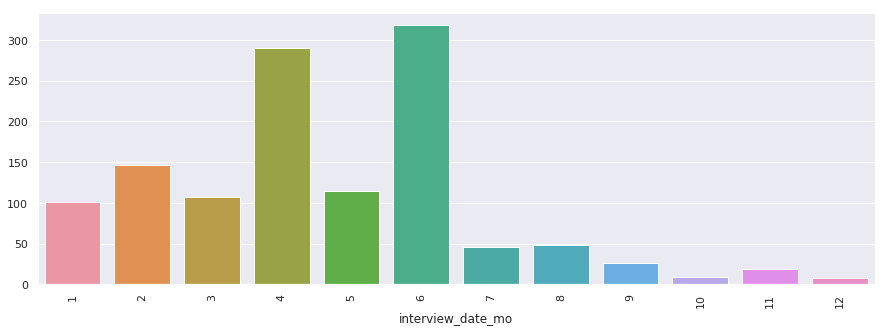

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
dt_histo = df.groupby('interview_date_mo').count()[['name']].reset_index()
g = sns.barplot(x=dt_histo['interview_date_mo'], y=dt_histo['name'], ax=ax)
g.set(xlabel='interview_date_mo', ylabel='')
for item in g.get_xticklabels():
    item.set_rotation(90)
    
#fig.autofmt_xdate()  
plt.show()  

## `pre-questions`
* Not a lot of diversity amongst the non-null pre-question responses.  May limit predictive "juice", if used as is.
* Only a little over 900 non-null pre-question responses. Perhaps it's better to indicate reponse/no response to question, as opposed to the actual answer?
* In spite of the small number of responses that are not `YES`, it may be very helpful to use categories with small reponse numbers that could be strong indicators of non-attendence.
* Also, it's probably more powerful to count how many negative (everything other than "YES") responses a candidate has, using nulls as "NO"

Let's go through these responses:  
* `q_start_time` *"Have you obtained the necessary permission to start at the required time"* If this is anything other than a yes, it could be prohibitive to attendence
* `q_unsch_mtgs` *"Hope there will be no unscheduled meetings"* This is something about unscheduled meetings and I'm assuming it's an indicator of whether the candidate anticipates unscheduled meetings which would preclude their attendance.
* `q_call_3hrs` *"Can I Call you three hours before the interview and follow up on your attendance for the interview"* This is more of a privacy/discretion issue, rather than an attendance indicator.  However, if the person is very skittish about "being found out" by their manager, then this might be something that decreses likelihood of attendence.
* `q_alt_number` *"Can I have an alternative number/ desk number? ..."* Another privacy issue that may indicate skittish-ness on the candidates' part
* `q_resume` *"Have you taken a printout of your updated resume. Have you read the JD and understood the same"* Two questions in one, hard to know response to individual questions.  Have to assume it's yes/no to both.
* `q_venue` *"Are you clear with the venue details and the landmark."* Not a clear indicator, but could in some cases be a weak indicator.
* `q_call_letter` *"Has the call letter been shared"* Apparently, in India a Call Letter is some kind of prompt for an examination. 

In [28]:
def clean_yes_no(s):
    tmp = s.strip().upper()
    if 'YES' in tmp:
        return 1
    else:
        return 0

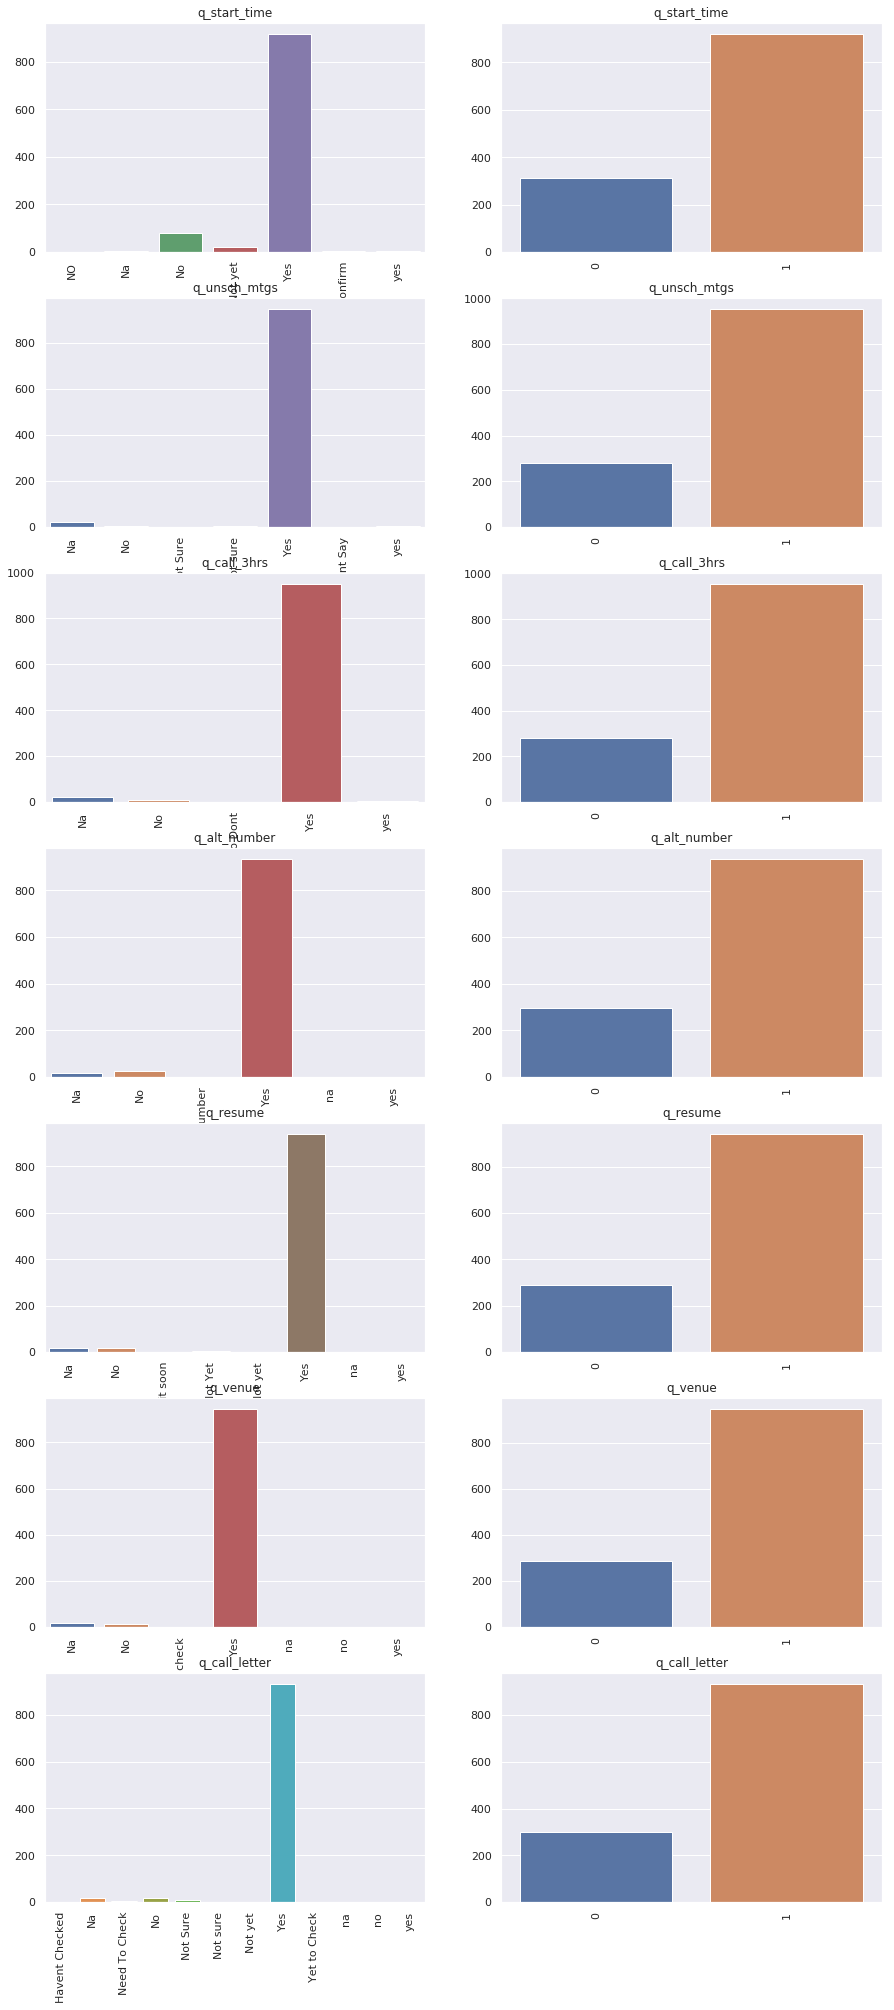

In [29]:
q_cols = ['q_start_time', 'q_unsch_mtgs', 'q_call_3hrs', 'q_alt_number', 'q_resume', 'q_venue', 'q_call_letter',]

fig, ax = plt.subplots(7, 2, figsize=(15, 30))
plt.subplots_adjust(bottom=0.01)

row_idx = 0
col_idx = 0

for col_name in q_cols:
    gp_by = df.groupby(col_name).count()[['name']].reset_index()
    gp_by_plot = sns.barplot(x=gp_by[col_name], y=gp_by['name'], ax=ax[row_idx][0])  
    ax[row_idx][0].set(xlabel='', ylabel='', title=col_name)
    for item in gp_by_plot.get_xticklabels():
        item.set_rotation(90)
        
    clean_col_name = f'{col_name}_clean'
    df[clean_col_name] = df[col_name].astype("object")    
    df[clean_col_name] = df[clean_col_name].fillna('NA').apply(clean_yes_no)
    
    gp_by = df.groupby(clean_col_name).count()[['name']].reset_index()
    gp_by_plot = sns.barplot(x=gp_by[clean_col_name], y=gp_by['name'], ax=ax[row_idx][1])  
    ax[row_idx][1].set(xlabel='', ylabel='', title=col_name)
    for item in gp_by_plot.get_xticklabels():
        item.set_rotation(90)
        
    row_idx += 1        

## `q_total`
### sum questions answered `YES`

In [30]:
df['q_total'] = df.loc[:,[f'{q}_clean' for q in q_cols]].sum(axis=1)
df.groupby('q_total').count()[['name']].reset_index()

,q_total,name
0,0,267
1,1,1
2,2,5
3,3,5
4,4,9
5,5,30
6,6,33
7,7,883


In [31]:
clean_cols = [
    'interview_date_mo',
    'client_name_clean',
    'industry_clean',
    'location_clean',
    'position_to_be_closed_clean',
    'gender_clean',
    'current_location_clean',
    'job_location_clean',
    'interview_venue_clean',
    'marital_clean',
    'interview_type_clean',
    'candidate_native_location_clean',
    'skillset_clean',
    'q_start_time_clean',
    'q_unsch_mtgs_clean',
    'q_call_3hrs_clean',
    'q_alt_number_clean',
    'q_resume_clean',
    'q_venue_clean',
    'q_call_letter_clean',
    'q_total',
    'name'
]

df_final = df[['attended_clean'] + clean_cols]

In [32]:
print(df_final.name.unique().shape[0], 'unique candidate names')

1233 unique candidate names


In [33]:
contingency_tbl = pd.crosstab(df['location_clean'], df['job_location_clean'], rownames=['location_clean'], colnames=['job_location_clean'])
contingency_tbl

job_location_clean,BANGALORE,CHENNAI,OTHER
location_clean,,,
BANGALORE,257,32,3
CHENNAI,2,836,2
OTHER,0,25,76


In [34]:
df_final.attended_clean.describe()

count    1140.000000
mean        0.639474
std         0.480364
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: attended_clean, dtype: float64

In [35]:
df_final.dtypes

attended_clean                     float64
interview_date_mo                    int64
client_name_clean                   object
industry_clean                      object
location_clean                      object
position_to_be_closed_clean         object
gender_clean                        object
current_location_clean              object
job_location_clean                  object
interview_venue_clean               object
marital_clean                       object
interview_type_clean                object
candidate_native_location_clean     object
skillset_clean                      object
q_start_time_clean                   int64
q_unsch_mtgs_clean                   int64
q_call_3hrs_clean                    int64
q_alt_number_clean                   int64
q_resume_clean                       int64
q_venue_clean                        int64
q_call_letter_clean                  int64
q_total                              int64
name                                object
dtype: obje

In [36]:
df_train = df_final[df_final['attended_clean'].notnull()]
df_submit = df_final[df_final['attended_clean'].isnull()]

In [37]:
df_train

,attended_clean,interview_date_mo,client_name_clean,industry_clean,location_clean,position_to_be_closed_clean,gender_clean,current_location_clean,job_location_clean,interview_venue_clean,marital_clean,interview_type_clean,candidate_native_location_clean,skillset_clean,q_start_time_clean,q_unsch_mtgs_clean,q_call_3hrs_clean,q_alt_number_clean,q_resume_clean,q_venue_clean,q_call_letter_clean,q_total,name
0,0.0,2,HOSPIRA,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,OTHER,OTHER,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,1,1,1,1,1,1,1,7,Candidate 1
1,0.0,2,HOSPIRA,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,BANGALORE,OTHER,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,1,1,1,1,1,1,1,7,Candidate 2
2,0.0,2,HOSPIRA,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,CHENNAI,OTHER,SINGLE,SCHEDULED_WALKIN,CHENNAI,OTHER,0,0,0,0,0,0,0,0,Candidate 3
3,0.0,2,HOSPIRA,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,CHENNAI,OTHER,SINGLE,SCHEDULED_WALKIN,CHENNAI,OTHER,1,1,0,1,0,1,1,5,Candidate 4
4,0.0,2,HOSPIRA,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,BANGALORE,OTHER,MARRIED,SCHEDULED_WALKIN,CHENNAI,OTHER,1,1,1,0,1,1,1,6,Candidate 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,1.0,7,PFIZER,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,CHENNAI,CHENNAI,MARRIED,SCHEDULED,BANGALORE,OTHER,1,1,1,1,1,1,1,7,Candidate 1229
1136,1.0,7,PFIZER,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,CHENNAI,CHENNAI,SINGLE,SCHEDULED,HYDERABAD,OTHER,1,1,1,1,1,1,1,7,Candidate 1230
1137,1.0,6,PFIZER,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,CHENNAI,CHENNAI,MARRIED,SCHEDULED,HYDERABAD,OTHER,1,1,1,1,1,1,1,7,Candidate 1231
1138,1.0,6,PFIZER,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,CHENNAI,CHENNAI,SINGLE,SCHEDULED,CHENNAI,OTHER,1,1,1,1,1,1,1,7,Candidate 1232


In [38]:
df_submit

,attended_clean,interview_date_mo,client_name_clean,industry_clean,location_clean,position_to_be_closed_clean,gender_clean,current_location_clean,job_location_clean,interview_venue_clean,marital_clean,interview_type_clean,candidate_native_location_clean,skillset_clean,q_start_time_clean,q_unsch_mtgs_clean,q_call_3hrs_clean,q_alt_number_clean,q_resume_clean,q_venue_clean,q_call_letter_clean,q_total,name
1140,NaN,2,OTHER,OTHER,OTHER,NICHE,FEMALE,OTHER,OTHER,OTHER,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,1,1,1,1,1,1,1,7,Candidate 10
1141,NaN,6,OTHER,OTHER,BANGALORE,NICHE,MALE,BANGALORE,BANGALORE,BANGALORE,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,1,1,1,1,1,1,1,7,Candidate 20
1142,NaN,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,NICHE,FEMALE,CHENNAI,CHENNAI,CHENNAI,MARRIED,SCHEDULED_WALKIN,CHENNAI,OTHER,1,1,1,1,1,1,1,7,Candidate 30
1143,NaN,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,NICHE,MALE,CHENNAI,CHENNAI,CHENNAI,MARRIED,SCHEDULED_WALKIN,CHENNAI,OTHER,1,1,1,1,1,1,1,7,Candidate 40
1144,NaN,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,ROUTINE,MALE,CHENNAI,CHENNAI,CHENNAI,SINGLE,SCHEDULED_WALKIN,CHENNAI,ORACLE,1,1,1,1,1,1,1,7,Candidate 50
1145,NaN,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,ROUTINE,FEMALE,CHENNAI,CHENNAI,CHENNAI,MARRIED,SCHEDULED_WALKIN,CHENNAI,ORACLE,1,1,1,1,1,1,1,7,Candidate 60
1146,NaN,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,ROUTINE,FEMALE,CHENNAI,CHENNAI,CHENNAI,MARRIED,SCHEDULED_WALKIN,CHENNAI,ORACLE,1,1,1,1,1,1,1,7,Candidate 70
1147,NaN,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,ROUTINE,MALE,CHENNAI,CHENNAI,CHENNAI,SINGLE,SCHEDULED_WALKIN,CHENNAI,ORACLE,1,1,1,1,1,1,1,7,Candidate 80
1148,NaN,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,ROUTINE,MALE,CHENNAI,CHENNAI,CHENNAI,MARRIED,SCHEDULED_WALKIN,CHENNAI,ORACLE,0,1,1,1,1,0,0,4,Candidate 90
1149,NaN,5,STANDARD CHARTERED BANK,BFSI,CHENNAI,ROUTINE,MALE,CHENNAI,CHENNAI,CHENNAI,SINGLE,SCHEDULED_WALKIN,CHENNAI,ACCOUNTING,1,1,1,1,1,1,1,7,Candidate 100


# Target Encoding
Do it here in Data Exploration/ETL step, so it's consistent across all model building efforts.

In [39]:
import h2o
#h2o.shutdown()
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,8 mins 36 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.1
H2O cluster version age:,1 month and 6 days
H2O cluster name:,H2O_from_python_mike_2ru0dt
H2O cluster total nodes:,1
H2O cluster free memory:,13.59 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [40]:
df_train_h2o = h2o.H2OFrame(df_train)
#df_train_h2o.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [41]:
df_submit_h2o = h2o.H2OFrame(df_submit)
df_submit_h2o['attended_clean'] = 0
#df_submit_h2o.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [42]:
target_encode_features = [
    'interview_date_mo',
    'industry_clean',
    'location_clean',
    'position_to_be_closed_clean',
    'gender_clean',
    'current_location_clean',
    'job_location_clean',
    'interview_venue_clean',
    'marital_clean',
    'interview_type_clean',
    'candidate_native_location_clean',
    'skillset_clean',
    'q_start_time_clean',
    'q_unsch_mtgs_clean',
    'q_call_3hrs_clean',
    'q_alt_number_clean',
    'q_resume_clean',
    'q_venue_clean',
    'q_call_letter_clean',
    'q_total',
]

for f in target_encode_features:
    df_train_h2o[f] = df_train_h2o[f].asfactor()
    df_submit_h2o[f] = df_submit_h2o[f].asfactor()
    
response_col_name = 'attended_clean'
df_train_h2o[response_col_name] = df_train_h2o[response_col_name].asfactor()
df_submit_h2o[response_col_name] = df_submit_h2o[response_col_name].asfactor()

train, test = df_train_h2o.split_frame(ratios=[.8,])

In [43]:
df_submit_h2o.describe()

Rows:93
Cols:23




,attended_clean,interview_date_mo,client_name_clean,industry_clean,location_clean,position_to_be_closed_clean,gender_clean,current_location_clean,job_location_clean,interview_venue_clean,marital_clean,interview_type_clean,candidate_native_location_clean,skillset_clean,q_start_time_clean,q_unsch_mtgs_clean,q_call_3hrs_clean,q_alt_number_clean,q_resume_clean,q_venue_clean,q_call_letter_clean,q_total,name
type,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,string
mins,,,,,,,,,,,,,,,,,,,,,,,NaN
mean,,,,,,,,,,,,,,,,,,,,,,,NaN
maxs,,,,,,,,,,,,,,,,,,,,,,,NaN
sigma,,,,,,,,,,,,,,,,,,,,,,,NaN
zeros,,,,,,,,,,,,,,,,,,,,,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,2,OTHER,OTHER,OTHER,NICHE,FEMALE,OTHER,OTHER,OTHER,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,1,1,1,1,1,1,1,7,Candidate 10
1,0,6,OTHER,OTHER,BANGALORE,NICHE,MALE,BANGALORE,BANGALORE,BANGALORE,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,1,1,1,1,1,1,1,7,Candidate 20
2,0,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,NICHE,FEMALE,CHENNAI,CHENNAI,CHENNAI,MARRIED,SCHEDULED_WALKIN,CHENNAI,OTHER,1,1,1,1,1,1,1,7,Candidate 30


In [44]:
test.describe()

Rows:224
Cols:23




,attended_clean,interview_date_mo,client_name_clean,industry_clean,location_clean,position_to_be_closed_clean,gender_clean,current_location_clean,job_location_clean,interview_venue_clean,marital_clean,interview_type_clean,candidate_native_location_clean,skillset_clean,q_start_time_clean,q_unsch_mtgs_clean,q_call_3hrs_clean,q_alt_number_clean,q_resume_clean,q_venue_clean,q_call_letter_clean,q_total,name
type,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,string
mins,,,,,,,,,,,,,,,,,,,,,,,NaN
mean,,,,,,,,,,,,,,,,,,,,,,,NaN
maxs,,,,,,,,,,,,,,,,,,,,,,,NaN
sigma,,,,,,,,,,,,,,,,,,,,,,,NaN
zeros,,,,,,,,,,,,,,,,,,,,,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,2,HOSPIRA,PHARMACEUTICALS,CHENNAI,NICHE,MALE,CHENNAI,BANGALORE,OTHER,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,1,1,1,1,1,1,1,7,Candidate 2
1,0,6,OTHER,OTHER,BANGALORE,NICHE,MALE,BANGALORE,BANGALORE,BANGALORE,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,0,1,1,1,1,1,0,5,Candidate 21
2,0,6,STANDARD CHARTERED BANK,BFSI,CHENNAI,NICHE,FEMALE,CHENNAI,CHENNAI,CHENNAI,SINGLE,SCHEDULED_WALKIN,OTHER,OTHER,1,1,1,0,1,1,0,5,Candidate 32


## Set up 3-fold validation scheme

In [45]:
train['fold'] = train.kfold_column(n_folds=3, seed=1234)

In [46]:
grouped = train.group_by(by=["fold"])
grouped.count()
grouped.get_frame()

fold,nrow
0,306
1,292
2,318


# Samples are stratified fairly well
They have nearly the same distribution of response variable for each fold and amongst train and test data sets

## Overall

In [47]:
train_strata = train.group_by(by=[response_col_name])
train_strata.count()
train_strata.get_frame()

attended_clean,nrow
0,335
1,581


## By Fold

In [48]:
train_strata = train.group_by(by=['fold', response_col_name])
train_strata.count()
train_strata.get_frame()

fold,attended_clean,nrow
0,0,112
0,1,194
1,0,109
1,1,183
2,0,114
2,1,204


## Test data set

In [49]:
test_strata = test.group_by(by=[response_col_name])
test_strata.count()
test_strata.get_frame()

attended_clean,nrow
0,76
1,148


# Target Encoding
### * For training data, we use the in-fold (training data for a fold) to train a `TargetEncoder` estimator and validate on the out-of-fold (test data for a fold), so the training data only uses training data to build target encodings for each fold, preventing leakage from out-of-fold into in-fold.
### * For test and submission data, we use the trained model mapping developed from the training data to simply map target encoding values.

In [50]:
from h2o.estimators.targetencoder import H2OTargetEncoderEstimator

te = H2OTargetEncoderEstimator(k=35,
                               f=25,
                               data_leakage_handling="k_fold",
                               fold_column='fold',
                               blending=True)

te.train(x=target_encode_features,
                 y=response_col_name,
                 training_frame=train)

train = te.transform(frame=train,
                     data_leakage_handling="k_fold",
                     seed=1234)

'''valid = titanic_te.transform(frame=valid,
                                   data_leakage_handling="none",
                                   noise=0,                                   
                                   seed=1234)'''

test = te.transform(frame=test, data_leakage_handling="none", noise=0, seed=1234)

submit = te.transform(frame=df_submit_h2o, data_leakage_handling="none", noise=0, seed=1234)

print('train:', train.nrows, 'test:', test.nrows)

targetencoder Model Build progress: |█████████████████████████████████████| 100%
train: 916 test: 224


In [51]:
#train.export_file('train.csv')
h2o.export_file(train, 'train.csv', force=True)
h2o.export_file(test, 'test.csv', force=True)
h2o.export_file(submit, 'submit.csv', force=True)

Export File progress: |███████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%
